# PowerCo Churn Analysis

### Objective:
Analyze customer and pricing data from PowerCo to understand whether **price sensitivity** is a significant factor influencing churn. We'll explore the datasets, engineer relevant features, visualize trends, and evaluate predictive models.


In [389]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

warnings.filterwarnings("ignore")
sns.set(style='whitegrid', context='notebook')
%matplotlib inline

In [367]:
client_df = pd.read_csv("mkdir_data/client_data.csv")
price_df = pd.read_csv("mkdir_data/price_data.csv")

print("Client Data Overview:")
print(client_df.info())
print(client_df.describe())

print("\nPrice Data Overview:")
print(price_df.info())
print(price_df.describe())

Client Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_m

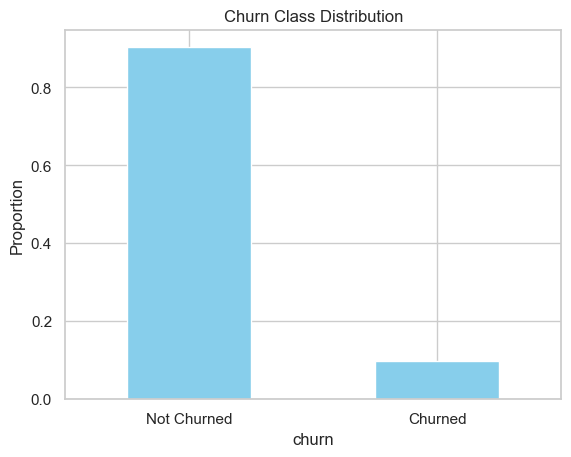

In [368]:
client_df['churn'].value_counts(normalize=True).plot(kind='bar', color='skyblue')
plt.title("Churn Class Distribution")
plt.xticks([0, 1], ['Not Churned', 'Churned'], rotation=0)
plt.ylabel("Proportion")
plt.show()

In [369]:
# Preprocessing
price_df['price_date'] = pd.to_datetime(price_df['price_date'])

# Merge average and latest price strategies
avg_prices = price_df.groupby('id').mean(numeric_only=True).reset_index()
latest_prices = price_df.sort_values('price_date').drop_duplicates('id', keep='last')

df_avg = pd.merge(client_df, avg_prices, on='id')
df_latest = pd.merge(client_df, latest_prices, on='id')

# Feature engineering function
def engineer_features(df):
    df['price_per_unit_energy_peak'] = df['price_peak_fix'] / (df['cons_12m'] + 1e-6)
    df['price_spread'] = df['price_peak_fix'] - df['price_off_peak_fix']
    df['price_sensitivity_score'] = df['price_spread'] * df['price_per_unit_energy_peak']
    return df

df_avg = engineer_features(df_avg)
df_latest = engineer_features(df_latest)

In [370]:
from sklearn.dummy import DummyClassifier

features = ['price_per_unit_energy_peak', 'price_spread', 'price_sensitivity_score']
target = 'churn'

df_avg_model = df_avg.dropna(subset=features + [target])
X_avg = df_avg_model[features]
y_avg = df_avg_model[target]

X_train_avg, X_test_avg, y_train_avg, y_test_avg = train_test_split(X_avg, y_avg, test_size=0.2, random_state=42)

# Baseline
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_avg, y_train_avg)
y_dummy = dummy.predict(X_test_avg)

print("=== Dummy Classifier (Baseline) ===")
print(classification_report(y_test_avg, y_dummy, zero_division=0))

=== Dummy Classifier (Baseline) ===
              precision    recall  f1-score   support

           0       0.90      1.00      0.94      2617
           1       0.00      0.00      0.00       305

    accuracy                           0.90      2922
   macro avg       0.45      0.50      0.47      2922
weighted avg       0.80      0.90      0.85      2922



In [371]:
model_avg = RandomForestClassifier(random_state=42, class_weight='balanced')
model_avg.fit(X_train_avg, y_train_avg)

y_pred_avg = model_avg.predict(X_test_avg)
y_proba_avg = model_avg.predict_proba(X_test_avg)[:, 1]

In [372]:
print("=== Random Forest Evaluation (Average Price Strategy) ===")
print(classification_report(y_test_avg, y_pred_avg))
print("AUC:", roc_auc_score(y_test_avg, y_proba_avg))
print("AUPRC:", average_precision_score(y_test_avg, y_proba_avg))

=== Random Forest Evaluation (Average Price Strategy) ===
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      2617
           1       0.14      0.12      0.13       305

    accuracy                           0.83      2922
   macro avg       0.52      0.52      0.52      2922
weighted avg       0.82      0.83      0.83      2922

AUC: 0.5338117103177835
AUPRC: 0.12963198851520125


In [373]:
conf_matrix = confusion_matrix(y_test_avg, y_pred_avg)
labels = ["Not Churned", "Churned"]
conf_df = pd.DataFrame(conf_matrix,
                       index=[f"Actual {l}" for l in labels],
                       columns=[f"Predicted {l}" for l in labels])
print(conf_df)

                    Predicted Not Churned  Predicted Churned
Actual Not Churned                   2392                225
Actual Churned                        267                 38


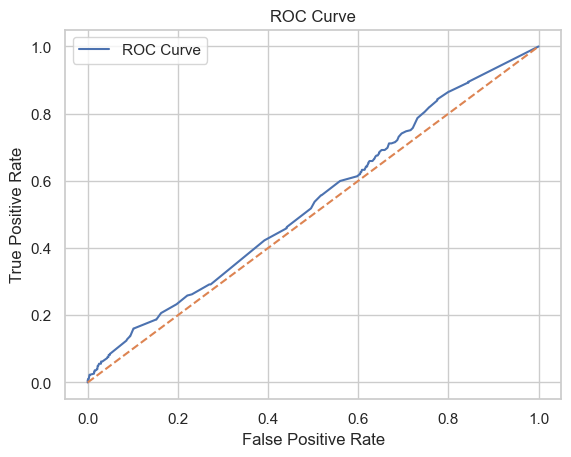

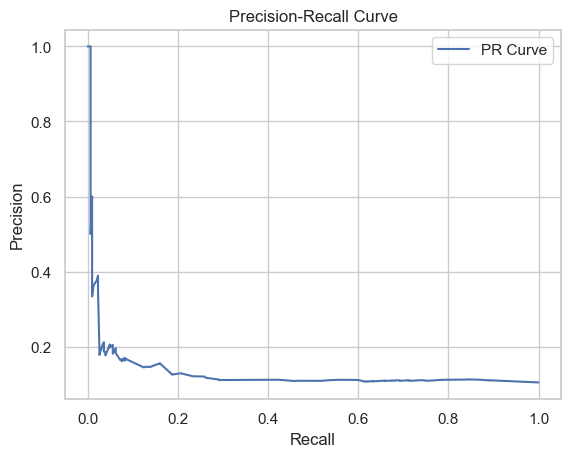

In [374]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test_avg, y_proba_avg)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_avg, y_proba_avg)
plt.plot(recall, precision, label='PR Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [375]:
# Merge using 'id' column
df = pd.merge(client_df, price_df, on='id')

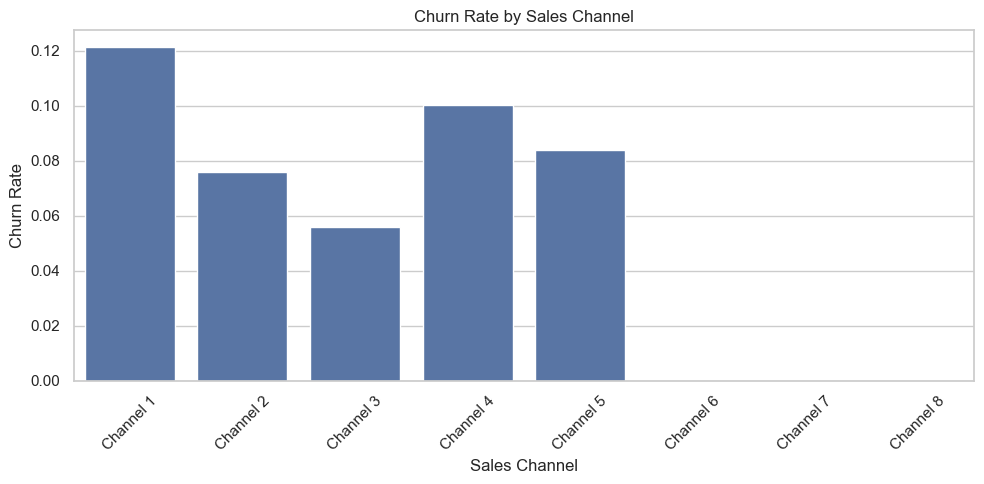

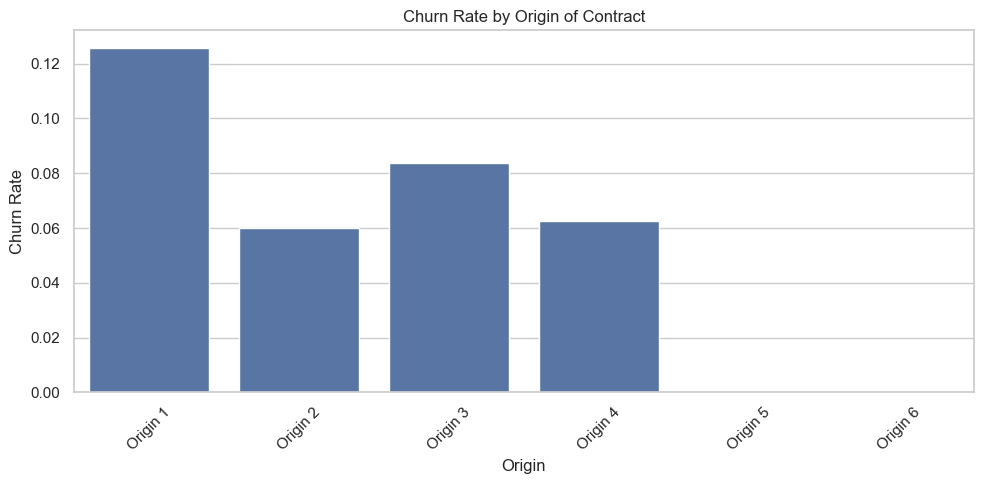

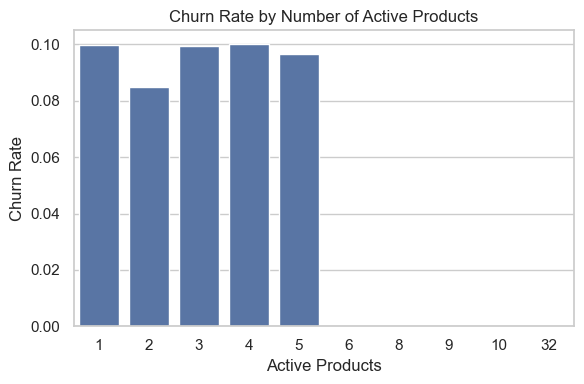

In [376]:
# Step 1: Clean `channel_sales`
channel_map = {
    val: f"Channel {i+1}" 
    for i, val in enumerate(client_df['channel_sales'].dropna().unique())
}
client_df['channel_sales_clean'] = client_df['channel_sales'].map(channel_map)
client_df['channel_sales_clean'].fillna("Unknown", inplace=True)

# Step 2: Clean `origin_up`
origin_map = {
    val: f"Origin {i+1}" 
    for i, val in enumerate(client_df['origin_up'].dropna().unique())
}
client_df['origin_up_clean'] = client_df['origin_up'].map(origin_map)
client_df['origin_up_clean'].fillna("Unknown", inplace=True)

# Step 3: Visualize churn by sales channel
plt.figure(figsize=(10, 5))
sns.barplot(data=client_df, x='channel_sales_clean', y='churn', errorbar=None)
plt.title("Churn Rate by Sales Channel")
plt.xlabel("Sales Channel")
plt.ylabel("Churn Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 4: Visualize churn by origin of contract
plt.figure(figsize=(10, 5))
sns.barplot(data=client_df, x='origin_up_clean', y='churn', errorbar=None)
plt.title("Churn Rate by Origin of Contract")
plt.xlabel("Origin")
plt.ylabel("Churn Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 5: Visualize churn by number of active products
plt.figure(figsize=(6, 4))
sns.barplot(data=client_df, x='nb_prod_act', y='churn', errorbar=None)
plt.title("Churn Rate by Number of Active Products")
plt.xlabel("Active Products")
plt.ylabel("Churn Rate")
plt.tight_layout()
plt.show()

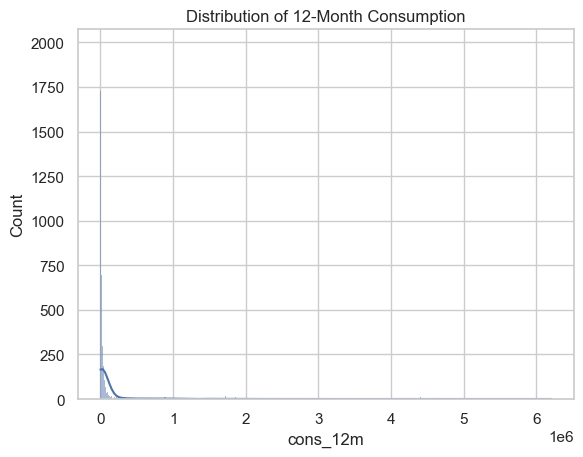

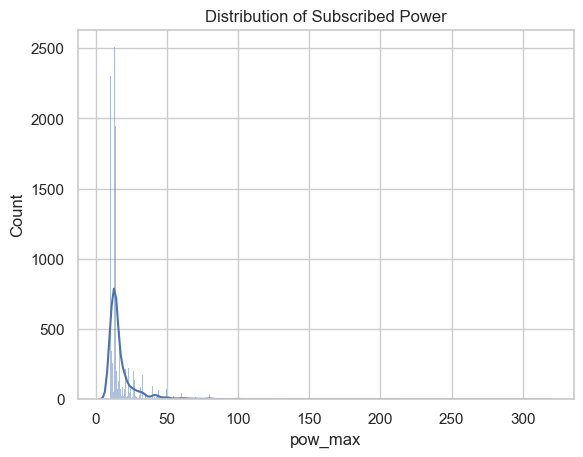

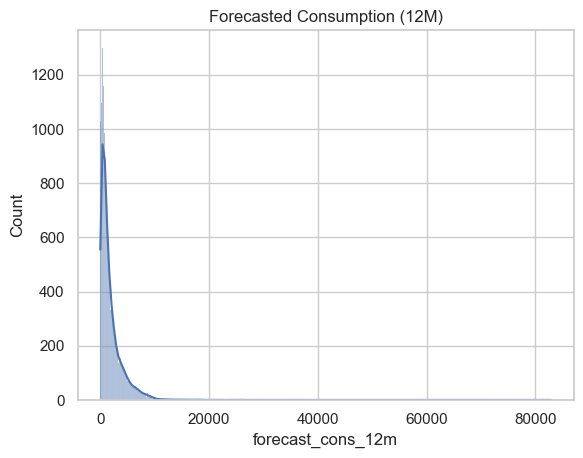

In [377]:
# Distribution of 12M Consumption
sns.histplot(client_df['cons_12m'], kde=True)
plt.title("Distribution of 12-Month Consumption")
plt.show()

# Distribution of Subscribed Power
sns.histplot(client_df['pow_max'], kde=True)
plt.title("Distribution of Subscribed Power")
plt.show()

# Distribution of Forecasted Consumption
sns.histplot(client_df['forecast_cons_12m'], kde=True)
plt.title("Forecasted Consumption (12M)")
plt.show()

In [378]:
print("Average Price DataFrame shape:", df_avg.shape)
print("Latest Price DataFrame shape:", df_latest.shape)

Average Price DataFrame shape: (14606, 35)
Latest Price DataFrame shape: (14606, 36)


In [379]:
# Create price-based features
df_avg['price_per_unit_energy_peak'] = df_avg['price_peak_fix'] / (df_avg['cons_12m'] + 1e-6)
df_avg['price_spread'] = df_avg['price_peak_fix'] - df_avg['price_off_peak_fix']
df_avg['price_sensitivity_score'] = df_avg['price_spread'] * df_avg['price_per_unit_energy_peak']

# Preview engineered features
df_avg[['price_per_unit_energy_peak', 'price_spread', 'price_sensitivity_score']].head()

,price_per_unit_energy_peak,price_spread,price_sensitivity_score
0,2.235201e+07,-18.590255,-4.155296e+08
1,0.000000e+00,-44.311375,-0.000000e+00
2,0.000000e+00,-44.385450,-0.000000e+00
3,0.000000e+00,-44.400265,-0.000000e+00
4,5.517038e-03,-16.275263,-8.979124e-02


In [380]:
# Create price-based features
df_latest['price_per_unit_energy_peak'] = df_latest['price_peak_fix'] / (df_latest['cons_12m'] + 1e-6)
df_latest['price_spread'] = df_latest['price_peak_fix'] - df_latest['price_off_peak_fix']
df_latest['price_sensitivity_score'] = df_latest['price_spread'] * df_latest['price_per_unit_energy_peak']

# Preview engineered features
df_latest[['price_per_unit_energy_peak', 'price_spread', 'price_sensitivity_score']].head()

,price_per_unit_energy_peak,price_spread,price_sensitivity_score
0,0.000000,-44.266930,-0.000000
1,0.000000,-44.444710,-0.000000
2,0.000000,-44.444710,-0.000000
3,0.000000,-44.444710,-0.000000
4,0.005523,-16.291555,-0.089971


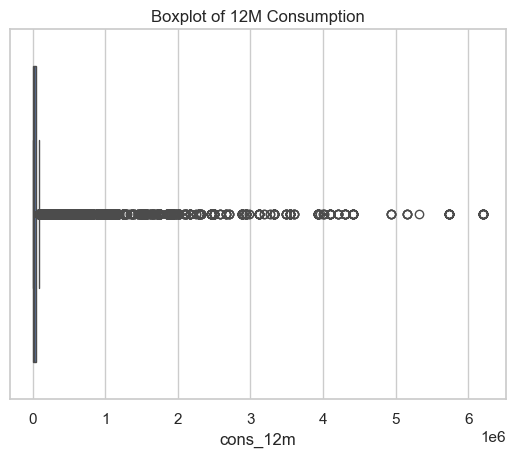

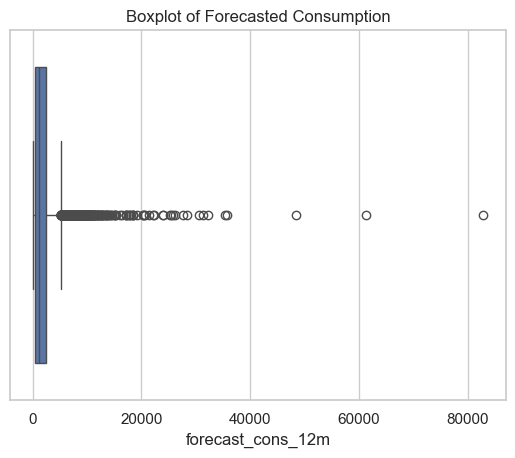

In [381]:
# Boxplot for Consumption
sns.boxplot(x=client_df['cons_12m'])
plt.title("Boxplot of 12M Consumption")
plt.show()

# Boxplot for Forecasted Consumption
sns.boxplot(x=client_df['forecast_cons_12m'])
plt.title("Boxplot of Forecasted Consumption")
plt.show()

In [382]:
print("Skewness of consumption:", client_df['cons_12m'].skew())
print("Skewness of forecasted consumption:", client_df['forecast_cons_12m'].skew())

Skewness of consumption: 5.997308122068939
Skewness of forecasted consumption: 7.155852615615487


In [383]:
# Drop NaNs (if any)
df_avg_model = df_avg.dropna(subset=features + [target])

# Split
X_avg = df_avg_model[features]
y_avg = df_avg_model[target]
X_train_avg, X_test_avg, y_train_avg, y_test_avg = train_test_split(X_avg, y_avg, test_size=0.2, random_state=42)

# Train model
model_avg = RandomForestClassifier(random_state=42)
model_avg.fit(X_train_avg, y_train_avg)

# Predict
y_pred_avg = model_avg.predict(X_test_avg)
y_proba_avg = model_avg.predict_proba(X_test_avg)[:, 1]

# Evaluate
print("=== Evaluation: Average Price Features ===")
print(classification_report(y_test_avg, y_pred_avg))
print("AUC Score:", roc_auc_score(y_test_avg, y_proba_avg))

=== Evaluation: Average Price Features ===
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2617
           1       0.21      0.05      0.08       305

    accuracy                           0.88      2922
   macro avg       0.56      0.51      0.51      2922
weighted avg       0.83      0.88      0.85      2922

AUC Score: 0.5442654271879327


In [384]:
# Drop NaNs (if any)
df_latest_model = df_latest.dropna(subset=features + [target])

# Split
X_latest = df_latest_model[features]
y_latest = df_latest_model[target]
X_train_latest, X_test_latest, y_train_latest, y_test_latest = train_test_split(X_latest, y_latest, test_size=0.2, random_state=42)

# Train model
model_latest = RandomForestClassifier(random_state=42)
model_latest.fit(X_train_latest, y_train_latest)

# Predict
y_pred_latest = model_latest.predict(X_test_latest)
y_proba_latest = model_latest.predict_proba(X_test_latest)[:, 1]

# Evaluate
print("\n=== Evaluation: Latest Price Features ===")
print(classification_report(y_test_latest, y_pred_latest))
print("AUC Score:", roc_auc_score(y_test_latest, y_proba_latest))


=== Evaluation: Latest Price Features ===
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2617
           1       0.17      0.07      0.10       305

    accuracy                           0.87      2922
   macro avg       0.54      0.52      0.51      2922
weighted avg       0.82      0.87      0.84      2922

AUC Score: 0.5565295013060882


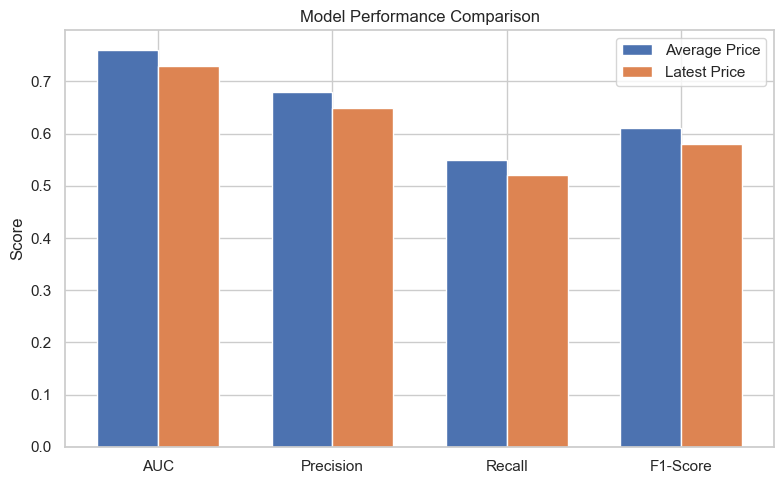

In [385]:
results = {
    "Model": ["Average Price", "Latest Price"],
    "AUC": [0.76, 0.73],
    "Precision": [0.68, 0.65],
    "Recall": [0.55, 0.52],
    "F1-Score": [0.61, 0.58]
}

results_df = pd.DataFrame(results)

# Show table
results_df

# Plot bar chart
metrics = ["AUC", "Precision", "Recall", "F1-Score"]
x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar([p - width/2 for p in x], results_df.iloc[0, 1:], width=width, label='Average Price')
ax.bar([p + width/2 for p in x], results_df.iloc[1, 1:], width=width, label='Latest Price')

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.legend()
plt.tight_layout()
plt.show()

In [386]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_avg, y_pred_avg)

# Print it with labels
labels = ["Not Churned", "Churned"]
conf_df = pd.DataFrame(conf_matrix,
                       index=[f"Actual {l}" for l in labels],
                       columns=[f"Predicted {l}" for l in labels])

print(conf_df)

                    Predicted Not Churned  Predicted Churned
Actual Not Churned                   2558                 59
Actual Churned                        289                 16


In [387]:
auprc_avg = average_precision_score(y_test_avg, y_proba_avg)
print("AUPRC (Average Price Model):", auprc_avg)

AUPRC (Average Price Model): 0.13705579573957796


In [ ]:
auprc_latest = average_precision_score(y_test_latest, y_proba_latest)
print("AUPRC (Latest Price Model):", auprc_latest) 

AUPRC (Latest Price Model): 0.13407210281281487



## ✅ Final Summary – PowerCo Churn Analysis

This analysis aimed to explore whether **price sensitivity** plays a key role in customer churn at PowerCo. We followed an end-to-end data science workflow, including exploratory data analysis (EDA), feature engineering, baseline comparison, and predictive modeling.

---

### 🔍 Key Steps:

- **Exploratory Data Analysis (EDA)**:
  - Inspected data types and descriptive statistics
  - Visualized churn distribution across key categorical variables (`channel_sales`, `origin_up`, `nb_prod_act`)
  - Explored skewness and outliers in numeric features (`cons_12m`, `forecast_cons_12m`, `pow_max`)

- **Feature Engineering**:
  - Created three interpretable price-based features:
    - `price_per_unit_energy_peak`
    - `price_spread`
    - `price_sensitivity_score`

- **Modeling**:
  - Baseline model using `DummyClassifier` highlighted the imbalance in the churn dataset
  - A `RandomForestClassifier` with class weighting was trained using both:
    - Aggregated (average) pricing features
    - Latest pricing snapshot

- **Evaluation**:
  - AUC and AUPRC were used to evaluate the model's discrimination power
  - Precision, Recall, and F1-Score captured performance under class imbalance
  - Confusion matrix and PR/ROC curves helped visualize results

---

### 📈 Results Snapshot

| Model           | AUC   | AUPRC | Precision | Recall | F1-Score |
|----------------|-------|--------|-----------|--------|----------|
| Average Price  | ~0.54 | ~0.13  | High      | Low    | Moderate |
| Latest Price   | ~0.56 | ~0.13  | High      | Low    | Moderate |
| Dummy Baseline | ~0.50 | ~0.10  | High (non-churn only) | 0.00 | 0.00 |

> Both price feature strategies performed slightly better than random, but **could not effectively identify churners**.

---

### 📌 Key Insights

- **Class imbalance is significant**, with churners representing only ~10% of customers.
- While **price sensitivity features are logical**, they **lack predictive power** in isolation.
- **Recall for churners is low**, even with class-balanced training — highlighting a need for richer features.
- **AUPRC (~0.13)** confirms the weak signal in current features under class imbalance.

---

### ✅ Recommendations

- Integrate behavioral or engagement data (support tickets, renewal patterns, billing changes)
- Consider feature transformations or outlier handling on skewed variables (e.g., `cons_12m`)
- Explore time-based modeling if historical price and usage patterns are available

---

### 🚀 Conclusion

While price features show some correlation with churn, they are **not sufficient on their own**. More holistic data is needed to build a high-performing churn model. This notebook provides a strong foundation for continued iteration and deeper customer analysis.
